In [1]:
using Revise
using Plots
using Scattering
using ProgressBars
using LaTeXStrings
import PyPlot
using PyCall
const plt = PyPlot;
using DelimitedFiles
using DataFrames
#pygui(true)
#%matplotlib inline

┌ Info: Precompiling Revise [295af30f-e4ad-537b-8983-00126c2a3abe]
└ @ Base loading.jl:1278
┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1278
┌ Info: Precompiling Scattering [ee89e84f-d0c9-46d3-af34-50d21503c048]
└ @ Base loading.jl:1278
┌ Info: Precompiling ProgressBars [49802e3a-d2f1-5c88-81d8-b72133a6f568]
└ @ Base loading.jl:1278
┌ Info: Precompiling PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1278
┌ Info: Precompiling DataFrames [a93c6f00-e57d-5684-b7b6-d8193f3e46c0]
└ @ Base loading.jl:1278


## Setup

In [6]:
matplotlib = pyimport("matplotlib")
function savefig(fig, name; dpi=196, kwargs...)
    path = joinpath("../latex/Figures/", name)
    fig.savefig(path, dpi=dpi, kwargs...)
end

function cmap(name, number)
    cm = plt.cm.get_cmap(name)
    Ncolors = min(cm.N, number)
    mapcolors = [cm(round(Int, x*cm.N/Ncolors)) for x in 1:Ncolors]
end

cmap (generic function with 1 method)

# The Potentials

## Square well

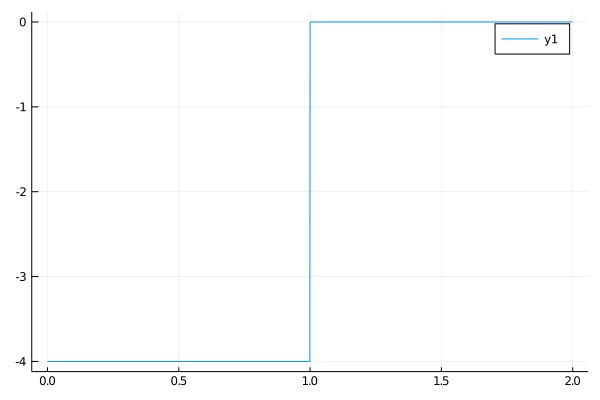

In [3]:
V = SquareWell(4.0)
r = 0.0001:0.001:2.0
plot(r, V.(r))

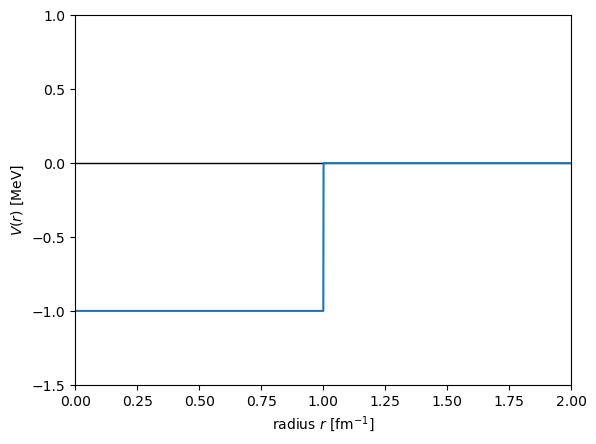

In [5]:
r = 1e-3:0.001:2.0

fig, ax = plt.subplots()
ax.axhline(y=0, c="k", linewidth=1)
ax.plot(r, SquareWell(1.0).(r))
ax.set_xlabel(L"radius $r$ [fm$^{-1}$]")
ax.set_ylabel(L"$V(r)$ [MeV]")
ax.set_ylim([-1.5, 1])
ax.set_xlim(0, 2)
savefig(fig, "squarewell.pdf")

## Exponential / Reid

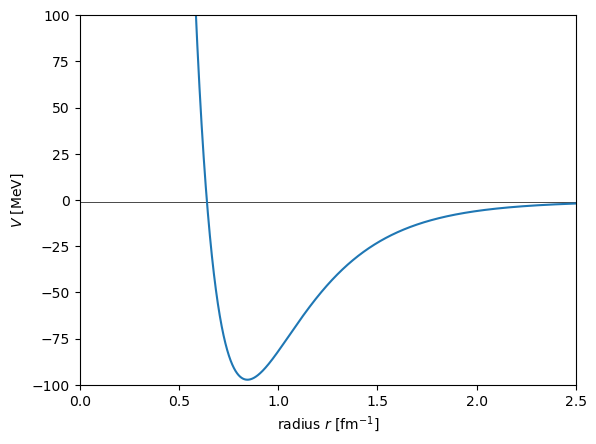

PyObject Text(26.28125, 0.5, '$V$ [MeV]')

In [5]:
r = 1e-3:0.0001:2.5
fig, ax = plt.subplots()
ax.axhline(y=-1, c="k", linewidth=0.5)
ax.plot(r, Reid().(r))
ax.set_ylim(-100, 100)
ax.set_xlim(0, 2.5)
ax.set_xlabel(L"radius $r$ [fm$^{-1}$]")
ax.set_ylabel(L"$V$ [MeV]")

# RMatrix method

In [6]:
# Use the reid potential and RMatrix method with N steps
V = Reid()
method = RMatrix(100)
# Mass of n+p in MeV in lab frame in units [fm⁻¹]
m = 2*(mₙ*mₚ)/(mₙ+mₙ) /197 
# Want more points near the peak
Mpeaks = 50
Mrest = 50
Mtot = Mpeaks + Mrest
# Compute for energies 0 - 300 MeV in laboratory frame
E = [range(0.0001, 5, length=Mpeaks)..., range(5, 150, length=Mrest)...]
k = .√(mass/197*E)

δ = phaseshift(k, mass, V, method)

fig, ax = plt.subplots()
ax.plot(2E, δ)
ax.axhline(y=0, c="k")

LoadError: UndefVarError: mass not defined

compare to models from http://nn-online.org/NN/?page=nnphsp2

In [238]:
raw = readdlm("../data/data.csv")
head, body = Symbol.(raw[1, :]), Float64.(raw[2:end, :])
data = DataFrame(body, head);
@show head;

head = [:T, :pwa93, :esc96, :nijm1, :nijm2, :nijm93]


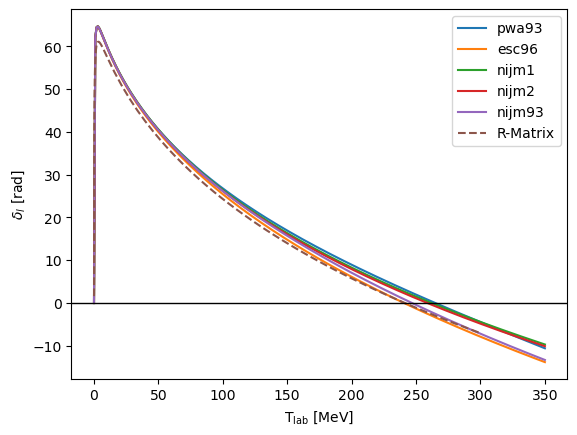

PyObject <matplotlib.legend.Legend object at 0x7fe2b93db370>

In [239]:
fig, ax = plt.subplots()
for model in head[2:end]
    ax.plot(data[:T], data[model], label=String(model))
end
ax.plot(2E, δ, label="R-Matrix", linestyle="--")
ax.axhline(y=0, c="k", linewidth=1)
ax.set_xlabel(L"$\mathrm{T}_{\mathrm{lab}}$ [MeV]")
ax.set_ylabel(L"$\delta_l$ [rad]")
ax.legend()

In [244]:
@show maximum(δ), 2E[argmax(δ)]
@show maximum(data[:nijm93]), data[:T][argmax(data[:nijm93])]

(maximum(δ), 2 * E[argmax(δ)]) = (61.083519131637374, 3.469518367346939)
(maximum(data[:nijm93]), (data[:T])[argmax(data[:nijm93])]) = (64.65006, 3.0)


(64.65006, 3.0)

# Variable Phase Approach

## The Square Well

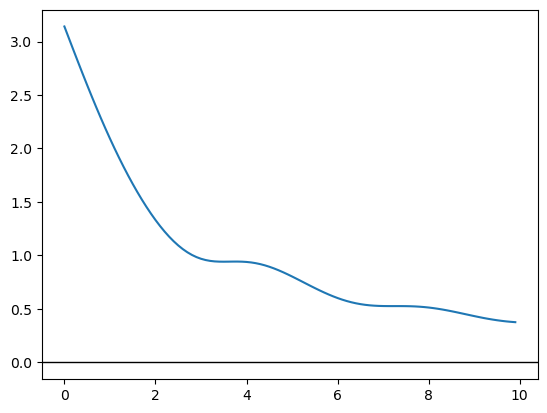

PyObject <matplotlib.lines.Line2D object at 0x7fe2b9196490>

In [219]:
# Use the reid potential and RMatrix method with N steps
V = SquareWell(4.0)
method = VPA()
# Mass of n+p in MeV in lab frame in units [fm⁻¹]
mass = (939.565 + 939.272)/2/197
mass = 2.0

# Compute the phase shift
k = 0.001:0.1:10
δ = phaseshift(k, mass, V, method, rspan=(0.001, 15.0))

# Plot the phase shift
fig, ax = plt.subplots()
ax.plot(k, δ)
ax.axhline(y=0, c="k", linewidth=1)

Compare with analytical solution for the square well

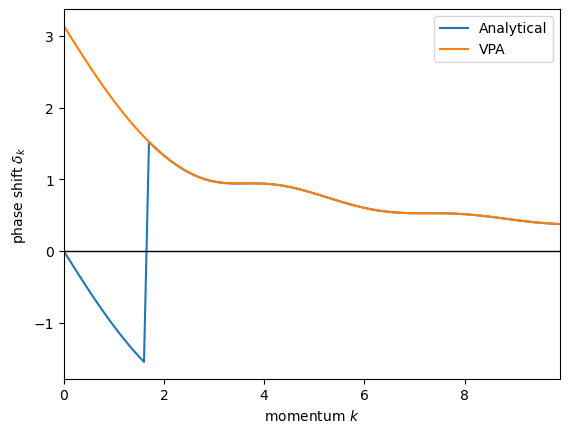

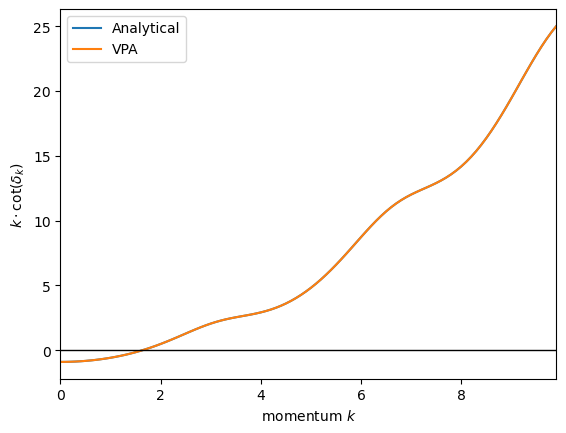

In [30]:
fig, ax = plt.subplots()
exact = analyticalsmooth(V, 1.0, Ek(k))
ax.plot(k, exact, label="Analytical")
ax.plot(k, δ, label="VPA")
ax.set_xlim(0, maximum(k))
ax.set_xlabel(L"momentum $k$")
ax.set_ylabel(L"phase shift $\delta_k$")
ax.axhline(y=0, c="k", linewidth=1)
ax.legend()

fig, ax = plt.subplots()
exact_smooth = @. k/tan(exact)
δ_smooth = @. k/tan(δ)
ax.plot(k, exact_smooth, label="Analytical")
ax.plot(k, δ_smooth, label="VPA")
ax.set_xlim(0, maximum(k))
ax.set_xlabel(L"momentum $k$")
ax.set_ylabel(L"$k \cdot \cot{(\delta_k)}$")
#ax.plot(k, 4π*sin.(deg2rad.(δ)).^2 ./k.^2)
ax.axhline(y=0, c="k", linewidth=1)
ax.legend()
savefig(fig, "analytical_cot.pdf")

In [67]:
matplotlib = pyimport("matplotlib")

function pi_ticks(ax)
    ticker = matplotlib.ticker.FormatStrFormatter(raw"$%g \: \pi$")
    locator = matplotlib.ticker.MultipleLocator(base=0.5)
    ax.set_major_formatter(ticker)
    ax.set_major_locator(locator)
end

pi_ticks (generic function with 1 method)

Square well at different depths

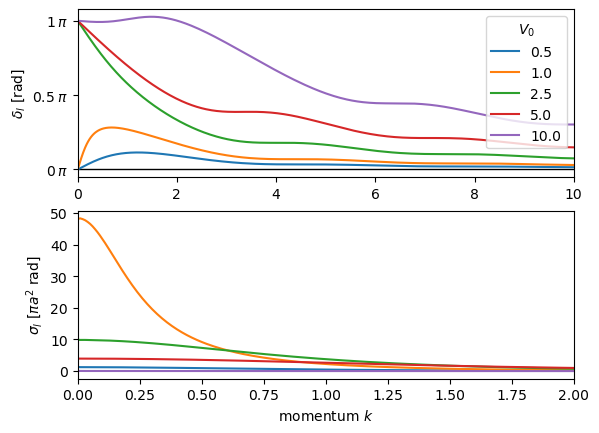

In [226]:
method = VPA()
mass = 2.0

# Compute the phase shift for different well depths V₀
k = 0.0:0.01:10 |> collect
k[1] += 0.001
δs = Vector{Float64}[]
V₀s = [0.5, 1.0, 2.5, 5.0, 10.0]
#V₀s = 1.20:0.01:1.25
for V₀ in V₀s
    V = SquareWell(V₀)
    δ = phaseshift(k, mass, V, method, rspan=(0.001, 15.0))
    push!(δs, δ)
end

# Plot the phase shift
fig, (ax1, ax2) = plt.subplots(nrows=2)
ax1.axhline(y=0, c="k", linewidth=1)
for (δ, V₀) in zip(δs, V₀s)
    ax1.plot(k, δ/π, label="$(V₀)")
    ax2.plot(k, crossection(δ, k)./π)
end
ax1.legend(title=L"$V_0$")
ax1.set_xlim(0, maximum(k))
ax2.set_xlim(0, 2)
ax2.set_xlabel(L"momentum $k$")
ax1.set_ylabel(L"$\delta_l$ [rad]")
ax2.set_ylabel(L"$\sigma_l$ [$\pi a^2$ rad]")
pi_ticks(ax1.yaxis)

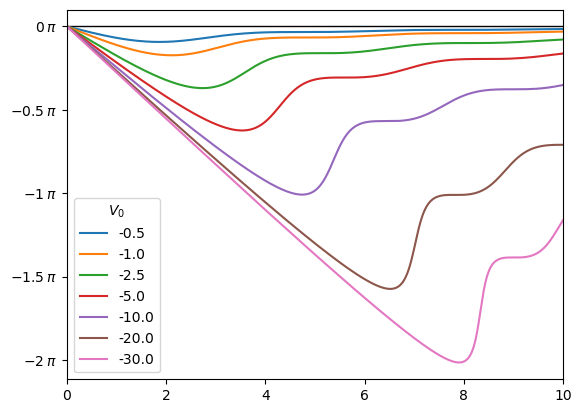

In [225]:
method = VPA()
mass = 2.0

# Compute the phase shift for different well depths V₀
k = 0.0:0.01:10 |> collect
k[1] += 0.001
δs = Vector{Float64}[]
V₀s = -[0.5, 1.0, 2.5, 5.0, 10.0, 20.0, 30.0]
#V₀s = 1.20:0.01:1.25
for V₀ in V₀s
    V = SquareWell(V₀)
    δ = phaseshift(k, mass, V, method, rspan=(0.001, 15.0))
    push!(δs, δ)
end

# Plot the phase shift
fig, ax = plt.subplots()
ax.axhline(y=0, c="k", linewidth=1)
for (δ, V₀) in zip(δs, V₀s)
    ax.plot(k, δ/π, label="$(V₀)")
end
ax.legend(title=L"$V_0$")
ax.set_xlim(0, maximum(k))
ax1.set_ylabel(L"$\delta_l$ [rad]")
pi_ticks(ax.yaxis)

## The Reid Potential

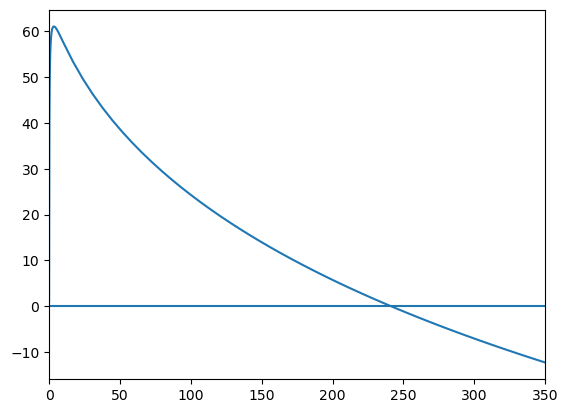

(2 * E[imax], k[imax], δmax |> rad2deg) = (3.4693877551020407, 0.20491547209121877, 61.083487796222414)


(0.0, 350.0)

In [236]:
# Use the Reid potential with VPA
V = Reid()
method = VPA()
# Mass of n+p in MeV in lab frame in units [fm⁻¹]
mass = (939.565 + 939.272)/2/197 
# Want more points near the peak
Mpeaks = 50
Mrest = 50
Mtot = Mpeaks + Mrest
# Compute for energies 0 - 350 MeV
E = [range(0, 5, length=Mpeaks)..., range(5, 175, length=Mrest)...]
k = .√(mass/197*E)
k[1] += 0.001

δ = phaseshift(k, mass, V, method, rspan=(0.0001, 150.0))
δmax = maximum(δ)
imax = argmax(δ)
@show 2E[imax], k[imax], δmax |> rad2deg
 
fig, ax = plt.subplots()
ax.plot(2E, δ .|> rad2deg)
ax.axhline(y=0)
ax.set_xlim(0, 350)

Investigate dependence on R_end

In [211]:
V = Reid()
method = VPA()

Rend = [0.1, 0.5, 1.0, 2.0, 5.0, 10.0, 15.0]
Δ = []
for rend in Rend
    δ = phaseshift(k, m, V, method, rspan=(1e-4, rend))
    push!(Δ, δ)
end

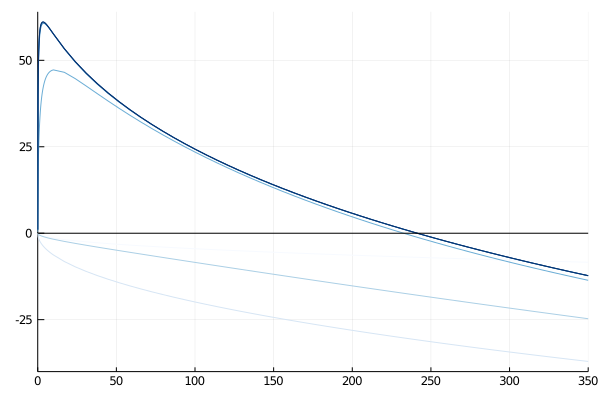

In [194]:
Plots.plot(2E, map(x -> rad2deg.(x), Δ), palette=Plots.palette(:Blues, length(Δ)), 
        legend=false, colorbar=:best, xlim=(0, 350))
Plots.plot!(2E, zeros(length(E)), color=:black)

In [ ]:
function boundedcolorbar(ax, cmap, bounds)
    mpl = pyimport("matplotlib")
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N, )
end

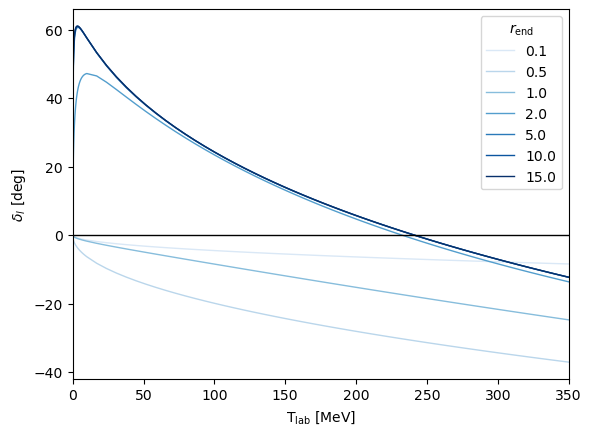

PyObject <matplotlib.legend.Legend object at 0x7fe2ba70fd60>

In [215]:
fig, ax = plt.subplots()
Δ_deg = map(x -> rad2deg.(x), Δ)
palette = cmap("Blues", length(Δ))
for (i, δ) in enumerate(Δ_deg)
    ax.plot(2E, δ, color=palette[i], linewidth=1, label=Rend[i])
end 
ax.axhline(y=0, color="k", linewidth=1)
ax.set_xlim(0, 350)
ax.set_xlabel(L"$\mathrm{T}_{\mathrm{lab}}$ [MeV]")
ax.set_ylabel(L"$\delta_l$ [deg]")
ax.legend(title=L"$r_{\mathrm{end}}$")

80.0%┣████████████████████████████████████         ┫ 4/5 [00:01<00:00, 3.0 it/s]

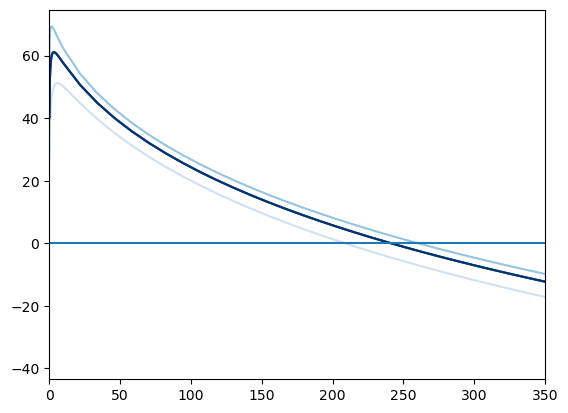

100.0%┣████████████████████████████████████████████┫ 5/5 [00:02<00:00, 1.8 it/s]


PyObject <matplotlib.lines.Line2D object at 0x7fe2b7494b50>

In [273]:
++(a, b) = append!(collect(a), collect(b))
M1 = 50
M2 = 50
M = M1 + M2
δ = zeros(M)
mn = 939.565
mp = 939.272
m = 2*(mn*mp)/(mn+mp) /197 
E = range(0, 5, length=M1) ++ range(5, 300, length=M2)
K0 = .√(m/197*E)
fig, ax = plt.subplots()
meshsize = [5, 10, 20, 50, 100]#, 200, 300]
cm = cmap("Blues", length(meshsize))
for (i, N) in enumerate(tqdm(meshsize))
    δ = [phaseshift(k0, m, Reid(), RMatrix(N)) for k0 in K0] #|> rad2deg
    ax.plot(2E, δ, "-", label="N = $N", color=cm[i])
end
ax.set_xlim(0, 350)
ax.axhline(y=0)
#plt.plot(E, δ, linestyle=:dot, markershape=:circle, markerstrokecolor=:white, markerstrokealpha=0.5, markersize=3)

Investigate dependence on $V_0$ and r_end for the Square Well potential

In [196]:
K = 0.001:0.01:20
@manipulate for rend=0.1:0.01:5.0, V0=-5.0:0.01:5.0
    V = SquareWell(2.0, V0)
    δ = [phaseshift(k, 1.0, V, VPA(), rspan=(1e-4, rend)) for k in K]
    plot(K, δ)
end

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["rend"], Dict{Symbol,Any}(:className => "interact ",:style => Dict{Any,Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol,Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol,Any}(:max => 491,:min => 1,:attributes => Dict{Any,Any}(:type => "range",Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}","orient" => "horizontal"),:step => 1,:className => "slider slider is-fullwidth",:style => Dict{Any,Any}()))], Dict{Symbol,Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol,Any}(:className => "interact-flex-row-right"))], Dict{Symbol,Any}(:className => "interact-flex-row interact-widget")), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing),"index" => (Observable{Any} with 2 listeners. Value:
246, nothing)), Set{String}(), nothing, Asset[Asset("js", "knockout", "/home/erdos/.julia/packages/Knockout/IP1uR/src/../assets/knockout.js"), Asset("js", "knockout_punches", "/home/erdos/.julia/packages/Knockout/IP1uR/src/../assets/knockout_punches.js"), Asset("js", nothing, "/home/erdos/.julia/packages/InteractBase/sOe2Z/src/../assets/all.js"), Asset("css", nothing, "/home/erdos/.julia/packages/InteractBase/sOe2Z/src/../assets/style.css"), Asset("css", nothing, "/home/erdos/.julia/packages/Interact/SbgIk/src/../assets/bulma_confined.min.css")], Dict{Any,Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")],"index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(sz_max:32,sz_curr:0), Set{AbstractConnection}(), Base.GenericCondition{Base.AlwaysLockedST}(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007fe2df74b0d0, Task (runnable) @0x00007fe2df74b0d0), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"0.1\",\"0.11\",\"0.12\",\"0.13\",\"0.14\",\"0.15\",\"0.16\",\"0.17\",\"0.18\",\"0.19\",\"0.2\",\"0.21\",\"0.22\",\"0.23\",\"0.24\",\"0.25\",\"0.26\",\"0.27\",\"0.28\",\"0.29\",\"0.3\",\"0.31\",\"0.32\",\"0.33\",\"0.34\",\"0.35\",\"0.36\",\"0.37\",\

Time the dependence on number of mesh points

In [72]:
# Use the reid potential and RMatrix method with N steps
V = Reid()
mass = 2*(mₙ*mₚ)/(mₙ+mₙ) /197 
# Want more points near the peak
Mpeaks = 50
Mrest = 50
Mtot = Mpeaks + Mrest
# Compute for energies 0 - 300 MeV in laboratory frame
E = [range(0.0001, 5, length=Mpeaks)..., range(5, 150, length=Mrest)...]
k = .√(mass/197*E)

Ns = 1:1:200
Ts = []
Allocateds = []
repetitions = 5
for N in Ns
    @show method = RMatrix(N)
    T_temp = []
    bytes = 0
    for i in 1:repetitions
        stats = @timed phaseshift(k, mass, V, RMatrix(N)) 
        bytes = stats.bytes
        push!(T_temp, stats.time)
    end
    push!(Ts, median(T_temp))
    push!(Allocateds, bytes)
end

method = RMatrix(N) = RMatrix(1)
method = RMatrix(N) = RMatrix(2)
method = RMatrix(N) = RMatrix(3)
method = RMatrix(N) = RMatrix(4)
method = RMatrix(N) = RMatrix(5)
method = RMatrix(N) = RMatrix(6)
method = RMatrix(N) = RMatrix(7)
method = RMatrix(N) = RMatrix(8)
method = RMatrix(N) = RMatrix(9)
method = RMatrix(N) = RMatrix(10)
method = RMatrix(N) = RMatrix(11)
method = RMatrix(N) = RMatrix(12)
method = RMatrix(N) = RMatrix(13)
method = RMatrix(N) = RMatrix(14)
method = RMatrix(N) = RMatrix(15)
method = RMatrix(N) = RMatrix(16)
method = RMatrix(N) = RMatrix(17)
method = RMatrix(N) = RMatrix(18)
method = RMatrix(N) = RMatrix(19)
method = RMatrix(N) = RMatrix(20)
method = RMatrix(N) = RMatrix(21)
method = RMatrix(N) = RMatrix(22)
method = RMatrix(N) = RMatrix(23)
method = RMatrix(N) = RMatrix(24)
method = RMatrix(N) = RMatrix(25)
method = RMatrix(N) = RMatrix(26)
method = RMatrix(N) = RMatrix(27)
method = RMatrix(N) = RMatrix(28)
method = RMatrix(N) = RMatrix(29)
method = RMatrix(N) = R

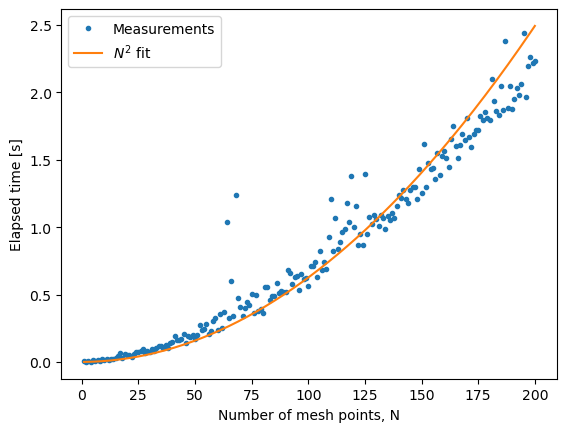

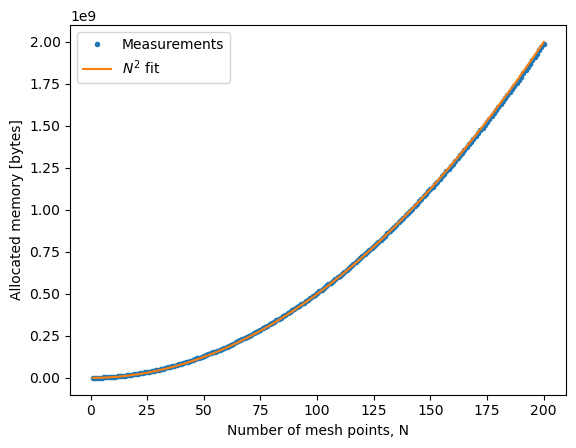

PyObject Text(24.00000000000002, 0.5, 'Allocated memory [bytes]')

In [105]:
fig, ax = plt.subplots()
ax.plot(Ns, Ts, ".", label="Measurements")
ax.plot(Ns, 3.1e-5(Ns.+1).* (Ns .+ Ns), label=L"$N^2$ fit")
ax.legend()
ax.set_xlabel("Number of mesh points, N")
ax.set_ylabel("Elapsed time [s]")

# Allocated bytes
fig, ax = plt.subplots()
ax.plot(Ns, Allocateds, ".", label="Measurements")
ax.plot(Ns, 5e4Ns.^2, label=L"$N^2$ fit")
ax.legend()
ax.set_xlabel("Number of mesh points, N")
ax.set_ylabel("Allocated memory [bytes]")

In [7]:
# Use the reid potential and RMatrix method with N steps
V = Reid()
method = RMatrix(50)
mass = 2*(mₙ*mₚ)/(mₙ+mₚ) /197 
# Want more points near the peak
repetitions = 10
lengths = 3:1:200
Ts_length = []
k = []
for length in lengths
    @show length
    E = 10 .^(range(log10(0.001), log10(150), length=length)) 
    k = .√(mass/197*E)
    Ts_temp = []
    for i in 1:repetitions
        T = @elapsed phaseshift(k, mass, V, method) 
        push!(Ts_temp, T)
    end
    push!(Ts_length, median(Ts_temp))
end

length = 3
length = 4
length = 5
length = 6
length = 7
length = 8
length = 9
length = 10
length = 11
length = 12
length = 13
length = 14
length = 15
length = 16
length = 17
length = 18
length = 19
length = 20
length = 21
length = 22
length = 23
length = 24
length = 25
length = 26
length = 27
length = 28
length = 29
length = 30
length = 31
length = 32
length = 33
length = 34
length = 35
length = 36
length = 37
length = 38
length = 39
length = 40
length = 41
length = 42
length = 43
length = 44
length = 45
length = 46
length = 47
length = 48
length = 49
length = 50
length = 51
length = 52
length = 53
length = 54
length = 55
length = 56
length = 57
length = 58
length = 59
length = 60
length = 61
length = 62
length = 63
length = 64
length = 65
length = 66
length = 67
length = 68
length = 69
length = 70
length = 71
length = 72
length = 73
length = 74
length = 75
length = 76
length = 77
length = 78
length = 79
length = 80
length = 81
length = 82
length = 83
length = 84
length = 85
length = 86

LoadError: InterruptException:

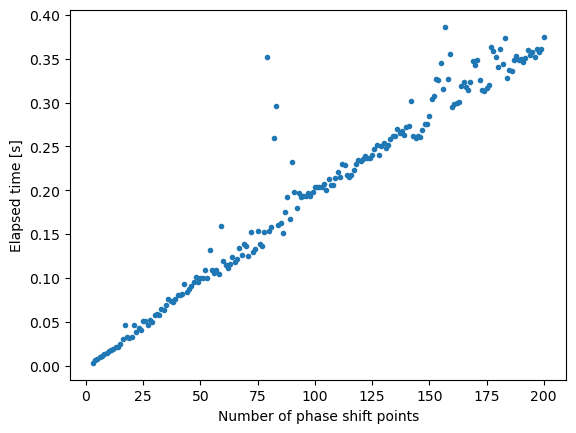

PyObject Text(24.000000000000007, 0.5, 'Elapsed time [s]')

In [54]:
fig, ax = plt.subplots()
ax.plot(lengths, Ts_length, ".")
ax.set_xlabel("Number of phase shift points")
ax.set_ylabel("Elapsed time [s]")

In [5]:
using BenchmarkTools

In [19]:
@benchmark δ = phaseshift(k, mass, V, RMatrix(50))

BenchmarkTools.Trial: 
  memory estimate:  113.41 MiB
  allocs estimate:  953499
  --------------
  minimum time:     242.193 ms (8.41% GC)
  median time:      308.801 ms (6.23% GC)
  mean time:        357.187 ms (6.53% GC)
  maximum time:     629.230 ms (6.30% GC)
  --------------
  samples:          14
  evals/sample:     1

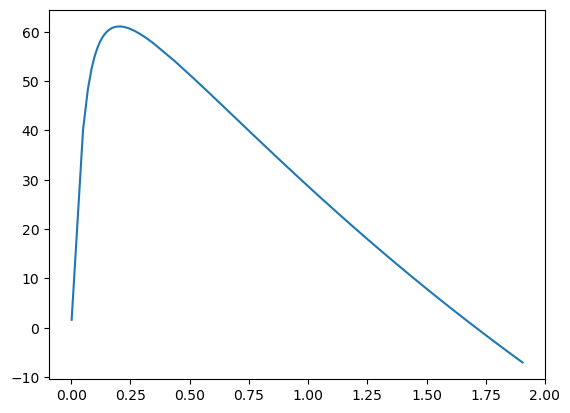

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f5c877ec9d0>

In [110]:
@benchmark δ = phaseshift(k, mass, V, RMatrix(50))
fig, ax = plt.subplots()
ax.plot(k, δ)

In [115]:
using StaticArrays

┌ Warning: Due to a previously reported error, the running code does not match saved version for the following files:
│ 
│   /home/erdos/.julia/dev/Scattering/src/rmatrix.jl
│ 
│ Use Revise.errors() to report errors again.
└ @ Revise /home/erdos/.julia/packages/Revise/BqeJF/src/Revise.jl:820


In [123]:
v = @SMatrix [(i,j) for i in 1:10, j in 1:10]

┌ Error: Failed to revise /home/erdos/.julia/dev/Scattering/src/rmatrix.jl
│   exception = (LoadError("/home/erdos/.julia/dev/Scattering/src/rmatrix.jl", 33, ErrorException("Use @SVector [a,b,c], @SVector Type[a,b,c] or a comprehension like [f(i) for i = i_min:i_max]")), Union{Ptr{Nothing}, Base.InterpreterIP}[Ptr{Nothing} @0x00007f5d41822af4, Ptr{Nothing} @0x00007f5c897edbeb, Ptr{Nothing} @0x00007f5d5205c027, Ptr{Nothing} @0x00007f5d5205f528, Ptr{Nothing} @0x00007f5d5205f260, Ptr{Nothing} @0x00007f5d5205f260, Ptr{Nothing} @0x00007f5d5205f260, Ptr{Nothing} @0x00007f5d5205f260, Ptr{Nothing} @0x00007f5d520606a1, Ptr{Nothing} @0x00007f5c8bd5a0a3])
└ @ Revise /home/erdos/.julia/packages/Revise/BqeJF/src/Revise.jl:760
┌ Warning: Due to a previously reported error, the running code does not match saved version for the following files:
│ 
│   /home/erdos/.julia/dev/Scattering/src/rmatrix.jl
│ 
│ Use Revise.errors() to report errors again.
└ @ Revise /home/erdos/.julia/packages/Revise/BqeJF/sr

10×10 SArray{Tuple{10,10},Tuple{Int64,Int64},2,100} with indices SOneTo(10)×SOneTo(10):
 (1, 1)   (1, 2)   (1, 3)   (1, 4)   …  (1, 7)   (1, 8)   (1, 9)   (1, 10)
 (2, 1)   (2, 2)   (2, 3)   (2, 4)      (2, 7)   (2, 8)   (2, 9)   (2, 10)
 (3, 1)   (3, 2)   (3, 3)   (3, 4)      (3, 7)   (3, 8)   (3, 9)   (3, 10)
 (4, 1)   (4, 2)   (4, 3)   (4, 4)      (4, 7)   (4, 8)   (4, 9)   (4, 10)
 (5, 1)   (5, 2)   (5, 3)   (5, 4)      (5, 7)   (5, 8)   (5, 9)   (5, 10)
 (6, 1)   (6, 2)   (6, 3)   (6, 4)   …  (6, 7)   (6, 8)   (6, 9)   (6, 10)
 (7, 1)   (7, 2)   (7, 3)   (7, 4)      (7, 7)   (7, 8)   (7, 9)   (7, 10)
 (8, 1)   (8, 2)   (8, 3)   (8, 4)      (8, 7)   (8, 8)   (8, 9)   (8, 10)
 (9, 1)   (9, 2)   (9, 3)   (9, 4)      (9, 7)   (9, 8)   (9, 9)   (9, 10)
 (10, 1)  (10, 2)  (10, 3)  (10, 4)     (10, 7)  (10, 8)  (10, 9)  (10, 10)

In [119]:
v

┌ Warning: Due to a previously reported error, the running code does not match saved version for the following files:
│ 
│   /home/erdos/.julia/dev/Scattering/src/rmatrix.jl
│ 
│ Use Revise.errors() to report errors again.
└ @ Revise /home/erdos/.julia/packages/Revise/BqeJF/src/Revise.jl:820


10-element SArray{Tuple{10},Int64,1,10} with indices SOneTo(10):
  1
  2
  3
  4
  5
  6
  7
  8
  9
 10

In [153]:
V = Reid()
K = range(0, 10, length=300)
S = zeros(length(K), length(K))
for (i, k) in enumerate(K), (j, k′) in enumerate(K)
    S[i, j] = V(k, k′)
end

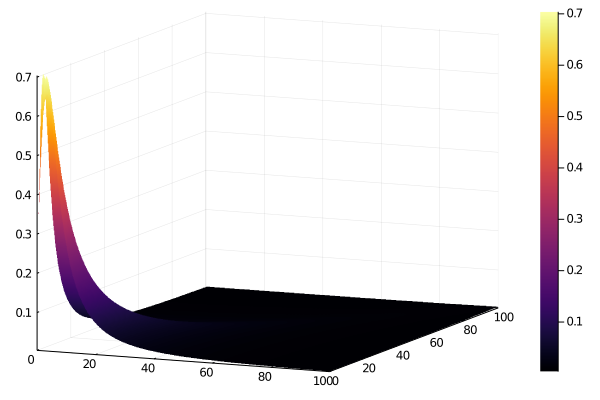

In [56]:
plot(K, K, S, st=:surface)

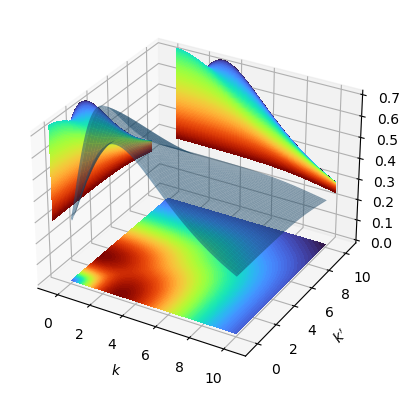

PyObject Text(0.07047665878555724, -0.07320235304988143, '$k^{\\prime}$')

In [181]:
fig = plt.figure()
ax = fig.gca(projection="3d")
X = repeat(K, 1, length(K))
Y = repeat(K', length(K), 1)

SS = copy(S)
SS[isnan.(SS)] .= 0.0

xoffset = -1
yoffset = 1

cset = ax.contourf(X, Y, S, zdir="x", offset=xoffset, cmap="turbo", levels=100)
cset = ax.contourf(X, Y, S, zdir="y", offset=maximum(K)+yoffset, cmap="turbo", levels=100)
cset = ax.contourf(X, Y, S, zdir="z", offset=zoffset, levels=100, cmap="turbo")
ax.plot_surface(X, Y, S, alpha=0.5, lw=0)
ax.set_xlim(xoffset, maximum(K)+yoffset)
ax.set_ylim(xoffset, maximum(K)+yoffset)
ax.set_zlim(zoffset, maximum(SS))
ax.set_xlabel(L"$k$")
ax.set_ylabel(L"$k^{\prime}$")

0.705692074941603

In [133]:
isnotnan

LoadError: UndefVarError: isnotnan not defined